In [1]:
import numpy as np
import MyML.EAC.full as myEacFull
import MyML.EAC.sparse as myEacSp
import MyML.EAC.eac as myEac
import MyML.cluster.K_Means3 as myKM
import MyML.helper.partition as myEacPart

/home/chiroptera/anaconda/lib/python2.7/site-packages/numba/cuda/decorators.py:106: UserWarning: autojit is deprecated and will be removed in a future release. Use jit instead.
  warn('autojit is deprecated and will be removed in a future release. Use jit instead.')


In [2]:
from sklearn.datasets import make_blobs

n_samples = 2000
data,gt = make_blobs(n_samples)
%time data = data.astype(np.float32)

generator = myKM.K_Means()
generator._MAX_THREADS_BLOCK = 256
%time ensemble = myEacPart.generateEnsemble(data, generator, n_clusters=[25,100],npartitions=100)

CPU times: user 32 µs, sys: 2 µs, total: 34 µs
Wall time: 42 µs
CPU times: user 1.49 s, sys: 111 ms, total: 1.6 s
Wall time: 1.61 s


In [8]:
reload(myEacFull)
reload(myEacPart)
reload(myEacSp)
reload(myEac)

<module 'MyML.cluster.eac' from '/home/chiroptera/workspace/QCThesis/MyML/cluster/eac.pyc'>

In [3]:
%time full = myEacFull.EAC_FULL(n_samples, condensed=False)
%time full.update_ensemble(ensemble)

CPU times: user 186 µs, sys: 11 µs, total: 197 µs
Wall time: 144 µs
CPU times: user 277 ms, sys: 7.77 ms, total: 284 ms
Wall time: 312 ms


In [4]:
%time cfull = myEacFull.EAC_FULL(n_samples, condensed=True)
%time cfull.update_ensemble(ensemble)

CPU times: user 254 µs, sys: 0 ns, total: 254 µs
Wall time: 190 µs
CPU times: user 323 ms, sys: 20.2 ms, total: 343 ms
Wall time: 338 ms


In [5]:
(full.coassoc == cfull.todense()).all()

True

In [45]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time sp = myEacSp.EAC_CSR(n_samples, max_assocs, condensed=False, sort_mode="numpy")
%time sp.update_ensemble(ensemble)

CPU times: user 116 µs, sys: 2 µs, total: 118 µs
Wall time: 105 µs
CPU times: user 3.08 s, sys: 3.58 ms, total: 3.09 s
Wall time: 3.09 s


In [46]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time sp2 = myEacSp.EAC_CSR(n_samples, max_assocs, condensed=False, sort_mode="surgical")
%time sp2.update_ensemble(ensemble)

CPU times: user 121 µs, sys: 3 µs, total: 124 µs
Wall time: 110 µs
CPU times: user 864 ms, sys: 263 µs, total: 865 ms
Wall time: 849 ms


In [37]:
sp._condense(keep_degree=True)
sp2._condense(keep_degree=True)
(sp.todense() == sp2.todense()).all()

True

In [47]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time csp = myEacSp.EAC_CSR(n_samples, max_assocs, condensed=True, sort_mode="numpy")
%time csp.update_ensemble(ensemble)

CPU times: user 274 µs, sys: 7 µs, total: 281 µs
Wall time: 224 µs
CPU times: user 1.98 s, sys: 3.77 ms, total: 1.98 s
Wall time: 1.98 s


In [39]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time csp2 = myEacSp.EAC_CSR(n_samples, max_assocs, condensed=True, sort_mode="surgical")
%time csp2.update_ensemble(ensemble)

CPU times: user 124 µs, sys: 4 µs, total: 128 µs
Wall time: 113 µs
CPU times: user 496 ms, sys: 8.01 ms, total: 504 ms
Wall time: 499 ms


In [40]:
csp._condense(keep_degree=True)
csp2._condense(keep_degree=True)

print "condensed numpy", ((csp.todense() + csp.todense().T) == full.coassoc).all()
print "condensed surgical", ((csp2.todense() + csp2.todense().T) == full.coassoc).all()

condensed numpy True
condensed surgical True


In [78]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time csp2 = myEacSp.EAC_CSR(n_samples, max_assocs, max_assocs_type='linear', condensed=True, sort_mode="surgical")
%time csp2.update_ensemble(ensemble)

CPU times: user 468 µs, sys: 76 µs, total: 544 µs
Wall time: 361 µs
CPU times: user 513 ms, sys: 79 µs, total: 513 ms
Wall time: 547 ms


In [79]:
csp2._condense(keep_degree=True)

In [80]:
print "condensed surgical", ((csp2.todense() + csp2.todense().T) == full.coassoc).all()

condensed surgical

NameError: name 'full' is not defined

# Linkage sparse

In [81]:
import scipy.sparse.csgraph as csgraph

In [82]:
coassoc = csp2.csr.copy()
coassoc.data = coassoc.data.max() + 1 - coassoc.data

In [83]:
mst = csgraph._min_spanning_tree.minimum_spanning_tree(coassoc).astype(np.uint8)

<Container object of 101 artists>

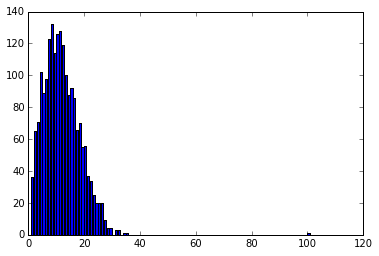

In [84]:
bcount = np.bincount(mst.data)
plt.bar(np.arange(bcount.size), bcount)

In [67]:
n_partitions = 100

In [86]:
mst

<2000x2000 sparse matrix of type '<type 'numpy.uint8'>'
	with 1998 stored elements in Compressed Sparse Row format>

In [138]:
np.unique(csgraph.connected_components(mst)[1])

array([0, 1], dtype=int32)

In [65]:
# converting to diassociations
coassoc.data = coassoc.data.max() + 1 - coassoc.data

# get minimum spanning tree
mst = csgraph._min_spanning_tree.minimum_spanning_tree(coassoc).astype(np.uint8)

# compute number of disconnected components
n_disconnects = mst.shape[0] - 1 - mst.nnz

# sort associations by weights
asort = mst.data.argsort()
sorted_weights = mst.data[asort]

if n_clusters = 0:
    # compute lifetimes
    lifetimes = sorted_weights[1:] - sorted_weights[:-1]

    # add 1 to n_partitions as the maximum weight because I also added
    # 1 when converting to diassoc to avoid having zero weights
    disconnect_lifetime = n_partitions + 1 - sorted_weights[-1]

    # maximum lifetime
    m_index = np.argmax(lifetimes)
    th = lifetimes[m_index]

    # get number of clusters from lifetimes
    indices = np.where(mst.data > mst.data[m_index])[0]
    if indices.size == 0:
        cont = 1
    else:
        cont = indices.size + 1

    #testing the situation when only 1 cluster is present
    # if maximum lifetime is smaller than 2 times the minimum
    # don't make any cuts (= 1 cluster)
    # max>2*min_interval -> nc=1
    close_to_zero_indices = np.where(np.isclose(lifetimes, 0))
    minimum = np.min(lifetimes[close_to_zero_indices])

    if th < 2 * minimum:
        cont = 1

    # cut associations if maximum lifetime is bigger than disconnect lifetime
    if th <= disconnect_lifetime:
        cont += n_disconnects

    nc_stable = cont
else:
    nc_stable = n_clusters

if nc_stable > n_disconnects:
    

In [66]:
nc_stable

2

In [ ]:
        if n_clusters == 0:
            # lifetime is here computed as the distance difference between 
            # any two consecutive nodes, i.e. the distance between passing
            # from n to n-1 clusters

            lifetimes = Z[1:,2] - Z[:-1,2]

            m_index = np.argmax(lifetimes)

            # Z is ordered in increasing order by weight of connection
            # the connection whose weight is higher than the one specified
            # by m_index MUST be the one from which the jump originated the
            # maximum lifetime; all connections above that (and including)
            # will be removed for the final clustering
            indices = np.where(Z[:,2] > Z[m_index, 2])[0]
            #indices = np.arange(m_index+1, Z.shape[0])
            if indices.size == 0:
                cont = 1
            else:
                cont = indices.size + 1

            # store maximum lifetime
            th = lifetimes[m_index]

            #testing the situation when only 1 cluster is present
            # if maximum lifetime is smaller than 2 times the minimum
            # don't make any cuts (= 1 cluster)
            #max>2*min_interval -> nc=1
            close_to_zero_indices = np.where(np.isclose(lifetimes, 0))
            minimum = np.min(lifetimes[close_to_zero_indices])

            if th < 2 * minimum:
                cont = 1

            nc_stable = cont

        else:
            nc_stable = n_clusters

        if nc_stable > 1:
            # only the labels are of interest

            labels = labels_from_Z(Z, n_clusters=nc_stable)

            # rename labels
            i=0
            for l in np.unique(labels):
                labels[labels == l] = i
                i += 1
        else:
            labels = np.zeros(self.n_samples, dtype = np.int32)

        self.labels_ = labels
        return labels

# plot stuff

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

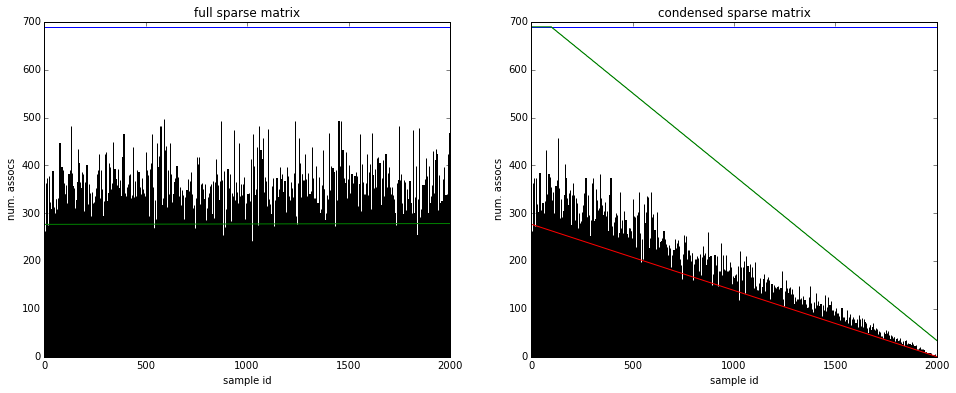

In [60]:
fig = plt.figure(figsize=(16,6))

x=np.arange(n_samples)

ax = fig.add_subplot(1,2,1)
ax.bar(x, sp.degree[:-1])
ax.plot([0,n_samples],[max_assocs, max_assocs])
fit = np.polyfit(x,sp.degree[:-1],1) # linear regression of degree
fit_fn = np.poly1d(fit) 
ax.plot(x, fit_fn(x))

ax.set_title("full sparse matrix")
ax.set_xlabel("sample id")
ax.set_ylabel("num. assocs")

ax = fig.add_subplot(1,2,2)
ax.bar(x, csp.degree[:-1]) # plot degree
ax.plot([0,n_samples],[max_assocs, max_assocs]) # plot max_assocs alloc

allocated_degree = csp2.indptr[1:] - csp2.indptr[:-1] # plot linear assoc
ax.plot(np.arange(sp.n_samples),allocated_degree)

fit = np.polyfit(x,csp.degree[:-1],1) # linear regression of degree
fit_fn = np.poly1d(fit) 
ax.plot(x, fit_fn(x))

ax.set_title("condensed sparse matrix")
ax.set_xlabel("sample id")
ax.set_ylabel("num. assocs")

In [58]:
fit_fn(x)

array([ 275.99378433,  275.85922344,  275.7246586 , ...,   -0.57809155,
         -0.72052195,   -0.8629563 ])

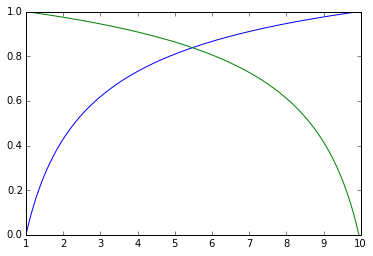

In [54]:
x = np.arange(1,10,0.05)
y = 1 / np.sqrt(x)
y = y.max() -y
y = y / y.max()
plt.plot(x,y)
plt.plot(x,y[::-1])
#plt.plot(x,np.sqrt(x)[::-1]/np.sqrt(x).max())

In [52]:
y.sum()

136.40980611903461

/home/chiroptera/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


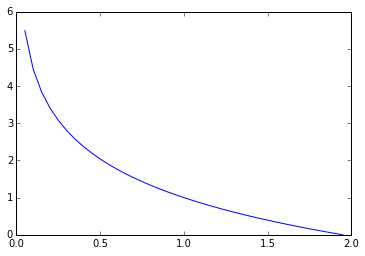

In [15]:
x = np.arange(0,2,0.05)
y = np.exp(x)
y /= y.max()
y = 1-y
plt.plot(x,y)

In [57]:
reload(myEacSp)

<module 'MyML.utils.sparse' from '/home/chiroptera/workspace/QCThesis/MyML/utils/sparse.pyc'>

In [60]:
y, y_sum = myEacSp.linear(n_samples, max_assocs, 0.1, 1, 1, 0.02)

In [61]:
total_area = n_samples * max_assocs
y_sum * 1.0 / total_area

0.55873891547049437

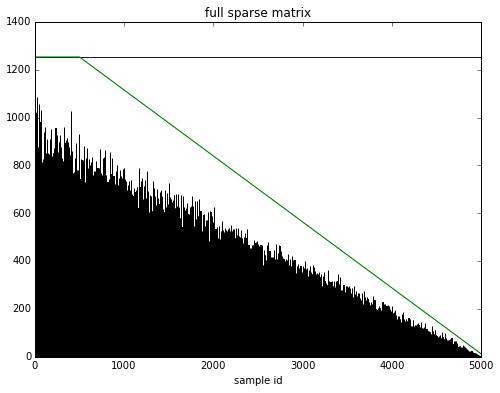

In [13]:
fig = plt.figure(figsize=(8,6))
x = np.arange(n_samples)
ax = fig.add_subplot(1,1,1)
ax.bar(x, csp.degree[:-1])
ax.plot([0,n_samples],[max_assocs, max_assocs])
#ax.plot(np.arange(n_samples), max_assoc_scheme)
ax.plot(x,y)

ax.set_title("full sparse matrix")
ax.set_xlabel("sample id")

In [67]:
import MyML.helper.scan as myScan
reload(myScan)

<module 'MyML.helper.scan' from '/home/chiroptera/workspace/QCThesis/MyML/helper/scan.py'>

In [63]:
y_c = y.copy()

In [71]:
y_sum

3503293

In [72]:
y_c

array([1254, 1254, 1254, ...,   25,   25, 5000], dtype=int32)

In [68]:
myScan.exprefixsumNumbaSingle(y)

3508293

In [77]:
class testme:
    def __init__(self,**kwargs):
        self.val2=kwargs.get("val2", 50)

In [80]:
a=testme(val2=100)
a.val2

100

In [73]:
y

array([      0,    1254,    2508, ..., 3503243, 3503268, 3503293], dtype=int32)

In [76]:
((y[1:] - y[:-1]) == y_c[:-1]).all()

True